In [13]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [157]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [158]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


# Mine

## check GPU

In [14]:
# let's see how many GPU we have?
ngpu = torch.cuda.device_count()
print(f"We have {ngpu} GPU(s) on this machine")

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
# print("GPU型号： ",torch.cuda.get_device_name(0))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

We have 0 GPU(s) on this machine
驱动为： cpu
Using cpu device


## load data

In [15]:
import torchio as tio
import pytorch_lightning as pl
import numpy as np

In [37]:
from collections import OrderedDict
def _sort_dict(d):
    return OrderedDict(sorted(d.items(), key=lambda t: t[0]))
# load data
INPUT = {
    'dm_velx': 'TNG-50-hydro-z0-dm-mesh-vx.npy',
    'dm_vely': 'TNG-50-hydro-z0-dm-mesh-vy.npy',
    'dm_velz': 'TNG-50-hydro-z0-dm-mesh-vz.npy',
    'dm_mass': 'TNG-50-hydro-z0-dm-mesh-v-num.npy'
}
OUTPUT = {
    'sub_mass': 'TNG-50-hydro-z0-subhalo-SubhaloMass.npy'
}
NUMS = {
    'dm': 'TNG-50-hydro-z0-dm-mesh-v-num.npy',
    'sub': 'TNG-50-hydro-z0-subhalo-Position.npy'
}
# sort dict
INPUT = _sort_dict(INPUT)
OUTPUT = _sort_dict(OUTPUT)
NUMS = _sort_dict(NUMS)

for key in NUMS.keys():
    exec('{} = np.load("{}")'.format(key+'_nums','./tmp_save/'+NUMS[key]))
# pre-processing
# divided by nums in each cell [get average num in each voxel]
for key in INPUT.keys():
    exec('{} = np.load("{}")'.format(key,'./tmp_save/'+INPUT[key]))
    # mass [log10]
    if key=='dm_mass':
        exec('{} = np.log10({}+1)'.format(key,key))
        pass
    # velocity [nan -> 0]
    else:
        exec('{} = np.divide({}, {})'.format(key,key,'dm_nums'))  # divide
        exec('np.nan_to_num({}, copy=False,nan=0)'.format(key))  # nan -> 0
    pass
for key in OUTPUT.keys():
    exec('{} = np.load("{}")'.format(key,'./tmp_save/'+OUTPUT[key]))
    if key == 'sub_mass':
        exec('{} = np.divide({}, {})'.format(key,key,'sub_nums'))  # divide
        exec('np.nan_to_num({}, copy=False,nan=0)'.format(key))  # nan -> 0
        exec('{} = np.log10({}+1)'.format(key,key))  # log10
    pass

# check nan or inf
for key in INPUT.keys():
    #exec('print({}.shape)'.format(key))
    exec('print("{}: ", {}.shape)'.format(key,key))
    exec('print("min: ",np.min({}))'.format(key))
    exec('print("max: ",np.max({}))'.format(key))
    pass
for key in OUTPUT.keys():
    exec('print("{}: ", {}.shape)'.format(key,key))
    exec('print("min: ",np.min({}))'.format(key))
    exec('print("max: ",np.max({}))'.format(key))
    pass

In [81]:
# numpy to torch tensor
def _arr2tensor(dict_keys):
    vals = []
    for key in dict_keys:
        exec('vals.append(torch.from_numpy({}))'.format(key))
        pass
    return torch.stack(vals)
input_3D = _arr2tensor(INPUT.keys())
output_3D = _arr2tensor(OUTPUT.keys())
print(input_3D.shape,output_3D.shape)

torch.Size([4, 640, 640, 640]) torch.Size([1, 640, 640, 640])


In [98]:
'''normalize
可选择 torchio.transforms.HistogramStandardization
首先直接尝试 rescale
'''
rescale11 = tio.RescaleIntensity(out_min_max=(-1, 1))
rescale01 = tio.RescaleIntensity(out_min_max=(0, 1))

# vel -> [-1, 1]
input_3D[1:] = rescale11(input_3D[1:])
# mass -> [0,1]
input_3D[:1] = rescale11(input_3D[:1])
output_3D[:1] = rescale11(output_3D[:1])

In [106]:
lala = transform(input_3D)

In [108]:
lala[8].shape

torch.Size([4, 64, 64, 64])

In [110]:
'''augmentation
original: 10x10x10 = 1000
using random center, we can get more samples!
'''
NUM_SAMPLES = 10000

transform = monai.transforms.RandSpatialCropSamples(
    roi_size = [64,64,64], 
    num_samples = NUM_SAMPLES,
    random_size=False
)

_inputs_3D = transform(input_3D)
_outputs_3D = transform(output_3D)

In [120]:
subjects = [
    tio.Subject(
        inputs = tio.ScalarImage(tensor = _in),
        outputs=tio.ScalarImage(tensor = _out)
    )
    for _in, _out in zip(_inputs_3D, _outputs_3D)
]
nums_test = int(0.2*len(subjects))
self.test_subjects = self.subjects[:nums_test]
self.subjects = self.subjects[nums_test:]

In [134]:
subjects = [
    tio.Subject(
        inputs = tio.ScalarImage(tensor = _in),
        outputs=tio.ScalarImage(tensor = _out)
    )
    for _in, _out in zip(_inputs_3D, _outputs_3D)
]
nums_test = int(0.2*len(subjects))
test_subjects = subjects[:nums_test]
subjects = subjects[nums_test:]

In [138]:
# def setup(self, stage=None):
train_val_ratio = 0.8
num_subjects = len(subjects)
num_train_subjects = int(round(num_subjects * train_val_ratio))
num_val_subjects = num_subjects - num_train_subjects
splits = num_train_subjects, num_val_subjects
train_subjects, val_subjects = random_split(subjects, splits)

transform = tio.Compose([tio.EnsureShapeMultiple(8)])

train_set = tio.SubjectsDataset(train_subjects, transform=transform)
val_set = tio.SubjectsDataset(val_subjects, transform=transform)
test_set = tio.SubjectsDataset(test_subjects, transform=transform)

In [121]:
# def setup(self, stage=None):
num_subjects = len(self.subjects)
num_train_subjects = int(round(num_subjects * self.train_val_ratio))
num_val_subjects = num_subjects - num_train_subjects
splits = num_train_subjects, num_val_subjects
train_subjects, val_subjects = random_split(self.subjects, splits)

self.transform = tio.Compose([tio.EnsureShapeMultiple(8)])

self.train_set = tio.SubjectsDataset(train_subjects, transform=self.transform)
self.val_set = tio.SubjectsDataset(val_subjects, transform=self.preprocess)
self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

ValueError: Input type not recognized: <class 'list'>

In [76]:
input_3D.shape

torch.Size([4, 640, 640, 640])

In [56]:
# self.subjects = []
#         for image_path, label_path in zip(image_training_paths, label_training_paths):
#             # 'image' and 'label' are arbitrary names for the images
#             subject = tio.Subject(
#                 image=tio.ScalarImage(image_path),
#                 label=tio.LabelMap(label_path)
#             )
#             self.subjects.append(subject)
# dm_vel_3D = tio.ScalarImage(tensor = torch.from_numpy(dm_vely))

for key in INPUT.keys():
    

dm_velx_3D = torch.from_numpy(dm_velx)
dm_vely_3D = torch.from_numpy(dm_vely)
dm_vel_3D = torch.stack((dm_velx_3D,dm_vely_3D))

dm_vel_3D = tio.ScalarImage(tensor = dm_vel_3D)

- [TorchIO revert/invert transform](https://torchio.readthedocs.io/transforms/transforms.html#invertibility)

若torchIO的inverse失败，我们可以完全抛弃torchIO，使用MONAI的[compose](https://docs.monai.io/en/latest/transforms.html?highlight=scale#compose)的方法：[inverse](https://docs.monai.io/en/latest/transforms.html?highlight=scale#monai.transforms.Compose.inverse)，结合[scaleintensity](https://docs.monai.io/en/latest/transforms.html?highlight=scale#scaleintensity)，即可实现逆转变换

- [MONAI crop 3D samples](https://docs.monai.io/en/latest/transforms.html#randspatialcropsamples)

In [55]:
dm_vel_3D.shape

RandSpatialCropSamples

# torchio 逆转
by the apply_inverse_transform() method of Subject.

# monai 逆转
monai.transforms.InvertibleTransform

torch.Size([2, 640, 640, 640])

In [46]:
# Loading from a file
t1_image = tio.ScalarImage('t1.nii.gz')
dmri = tio.ScalarImage(tensor=torch.rand(32, 128, 128, 88))
image = tio.ScalarImage('safe_image.nrrd', check_nans=False)
data, affine = image.data, image.affine
affine.shape
image.data is image[tio.DATA]
image.data is image.tensor
type(image.data)

In [144]:
import torch
from torch.utils.data import random_split, DataLoader
import monai
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

class nbody2hydroDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir, batch_size, train_val_ratio):
        super().__init__()
        self.batch_size = batch_size
        self.dataset_dir = dataset_dir
        self.train_val_ratio = train_val_ratio
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None
        
    def prepare_data(self):
        '''load data
        1. get average value in each cell
        2. convert nan -> 0
        3. convert mass [log10]
        '''
        def _sort_dict(d):
            return OrderedDict(sorted(d.items(), key=lambda t: t[0]))
        # load data
        INPUT = {
            'dm_velx': 'TNG-50-hydro-z0-dm-mesh-vx.npy',
            'dm_vely': 'TNG-50-hydro-z0-dm-mesh-vy.npy',
            'dm_velz': 'TNG-50-hydro-z0-dm-mesh-vz.npy',
            'dm_mass': 'TNG-50-hydro-z0-dm-mesh-v-num.npy'
        }
        OUTPUT = {
            'sub_mass': 'TNG-50-hydro-z0-subhalo-SubhaloMass.npy'
        }
        NUMS = {
            'dm': 'TNG-50-hydro-z0-dm-mesh-v-num.npy',
            'sub': 'TNG-50-hydro-z0-subhalo-Position.npy'
        }
        # sort dict
        INPUT = _sort_dict(INPUT)
        OUTPUT = _sort_dict(OUTPUT)
        NUMS = _sort_dict(NUMS)

        for key in NUMS.keys():
            exec('{} = np.load("{}")'.format(key+'_nums',self.dataset_dir+NUMS[key]))
        # pre-processing
        # divided by nums in each cell [get average num in each voxel]
        for key in INPUT.keys():
            exec('{} = np.load("{}")'.format(key,self.dataset_dir+INPUT[key]))
            # mass [log10]
            if key=='dm_mass':
                exec('{} = np.log10({}+1)'.format(key,key))
                pass
            # velocity [nan -> 0]
            else:
                exec('{} = np.divide({}, {})'.format(key,key,'dm_nums'))  # divide
                exec('np.nan_to_num({}, copy=False,nan=0)'.format(key))  # nan -> 0
            pass
        for key in OUTPUT.keys():
            exec('{} = np.load("{}")'.format(key,self.dataset_dir+OUTPUT[key]))
            if key == 'sub_mass':
                exec('{} = np.divide({}, {})'.format(key,key,'sub_nums'))  # divide
                exec('np.nan_to_num({}, copy=False,nan=0)'.format(key))  # nan -> 0
                exec('{} = np.log10({}+1)'.format(key,key))  # log10
            pass

        ## check nan or inf
        #for key in INPUT.keys():
        #    #exec('print({}.shape)'.format(key))
        #    exec('print("{}: ", {}.shape)'.format(key,key))
        #    exec('print("min: ",np.min({}))'.format(key))
        #    exec('print("max: ",np.max({}))'.format(key))
        #    pass
        #for key in OUTPUT.keys():
        #    exec('print("{}: ", {}.shape)'.format(key,key))
        #    exec('print("min: ",np.min({}))'.format(key))
        #    exec('print("max: ",np.max({}))'.format(key))
        #    pass
        # numpy to torch tensor
        def _arr2tensor(dict_keys):
            vals = []
            for key in dict_keys:
                exec('vals.append(torch.from_numpy({}))'.format(key))
                pass
            return torch.stack(vals)
        input_3D = _arr2tensor(INPUT.keys())
        output_3D = _arr2tensor(OUTPUT.keys())
        #print(input_3D.shape,output_3D.shape)
        '''normalize
        可选择 torchio.transforms.HistogramStandardization
        首先直接尝试 rescale
        '''
        rescale11 = tio.RescaleIntensity(out_min_max=(-1, 1))
        rescale01 = tio.RescaleIntensity(out_min_max=(0, 1))

        # vel -> [-1, 1]
        input_3D[1:] = rescale11(input_3D[1:])
        # mass -> [0,1]
        input_3D[:1] = rescale11(input_3D[:1])
        output_3D[:1] = rescale11(output_3D[:1])
        '''augmentation
        original: 10x10x10 = 1000
        using random center, we can get more samples!
        '''
        NUM_SAMPLES = 10000

        transform = monai.transforms.RandSpatialCropSamples(
            roi_size = [64,64,64], 
            num_samples = NUM_SAMPLES,
            random_size=False
        )

        _inputs_3D = transform(input_3D)
        _outputs_3D = transform(output_3D)
        self.subjects = [
            tio.Subject(
                inputs = tio.ScalarImage(tensor = _in),
                outputs=tio.ScalarImage(tensor = _out)
            )
            for _in, _out in zip(_inputs_3D, _outputs_3D)
        ]
        nums_test = int(0.2*len(subjects))
        self.test_subjects = self.subjects[:nums_test]
        self.subjects = self.subjects[nums_test:]

    def setup(self, stage=None):
        num_subjects = len(self.subjects)
        num_train_subjects = int(round(num_subjects * self.train_val_ratio))
        num_val_subjects = num_subjects - num_train_subjects
        splits = num_train_subjects, num_val_subjects
        train_subjects, val_subjects = random_split(self.subjects, splits)

        self.transform = tio.Compose([tio.EnsureShapeMultiple(8)])

        self.train_set = tio.SubjectsDataset(train_subjects, transform=self.transform)
        self.val_set = tio.SubjectsDataset(val_subjects, transform=self.preprocess)
        self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)
    
    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size)

In [147]:
import os
HOME = os.path.expandvars('$HOME')

data = nbody2hydroDataModule(
    dataset_dir=HOME+'/code/nbody2hydro/tmp_save/',
    batch_size=8,
    train_val_ratio=0.8,
)
data.prepare_data()
data.setup()
print('Training:  ', len(data.train_set))
print('Validation: ', len(data.val_set))
print('Test:      ', len(data.test_set))

<string>:1: RuntimeWarning: invalid value encountered in true_divide


Training:   6720
Validation:  1680
Test:       1600


In [148]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, x):
        y_hat = self.net(x)
        return y_hat
    
    def prepare_batch(self, batch):
        return batch['inputs'][tio.DATA], batch['outputs'][tio.DATA]
    
    #def infer_batch(self, batch):
    #    x, y = self.prepare_batch(batch)
    #    y_hat = self.net(x)
    #    return y_hat, y

    def training_step(self, batch, batch_idx):
        x, y = self.prepare_batch(batch)
        y_hat = self(x)
        #y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = self.prepare_batch(batch)
        y_hat = self(x)
        #y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = self.prepare_batch(batch)
        y_hat = self(x)
        #y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        print(f"test loss is {loss}")
        return loss

In [149]:
unet = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=4,
    out_channels=1,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2),
)

model = Model(
    net=unet,
    criterion=nn.MSELoss(), #F.mse_loss() #monai.losses.DiceCELoss(softmax=True),
    learning_rate=1e-3,
    optimizer_class=torch.optim.AdamW,
)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss',
)
trainer = pl.Trainer(
    #gpus=1,
    precision=16,
    callbacks=[early_stopping],
)
trainer.logger._default_hp_metric = False

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


MisconfigurationException: You have asked for native AMP on CPU, but AMP is only available on GPU.

In [2]:
from torch.nn import functional as F
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Examples
**MONAI官方API**
> [Unet](https://docs.monai.io/en/latest/networks.html#unet)   
> [VNet](https://docs.monai.io/en/latest/networks.html#vnet)

In [ ]:
def conv3x3x3(inplane, outplane, stride=1,padding=0,kernel_size=3):
    """
    Simple 3x3x3 convolutional block. 
    """
    return nn.Conv3d(inplane,outplane,kernel_size=kernel_size,stride=stride,padding=padding,bias=True)

## U-Net 示例

In [ ]:
import torch
import torch.nn as nn
from periodic_padding import periodic_padding_3d
from data_utils import crop_tensor
import numpy as np

def conv3x3(inplane,outplane, stride=1,padding=0):
	return nn.Conv3d(inplane,outplane,kernel_size=3,stride=stride,padding=padding,bias=True)

class BasicBlock(nn.Module):
	def __init__(self,inplane,outplane,stride = 1):
		super(BasicBlock, self).__init__()
		self.conv1 = conv3x3(inplane,outplane,padding=0,stride=stride)
		self.bn1 = nn.BatchNorm3d(outplane)
		self.relu = nn.ReLU(inplace=True)

	def forward(self,x):
		x = periodic_padding_3d(x,pad=(1,1,1,1,1,1))
		out = self.conv1(x)
		out = self.bn1(out)
		out = self.relu(out)
		return out

class Lpt2NbodyNet(nn.Module):
	def __init__(self, block):
		super(Lpt2NbodyNet,self).__init__()
		self.layer1 = self._make_layer(block, 3, 64, blocks=2,stride=1)
		self.layer2 = self._make_layer(block,64,128, blocks=1,stride=2)
		self.layer3 = self._make_layer(block,128,128,blocks=2,stride=1)
		self.layer4 = self._make_layer(block,128,256,blocks=1,stride=2)
		self.layer5 = self._make_layer(block,256,256,blocks=2,stride=1)
		self.deconv1 = nn.ConvTranspose3d(256,128,3,stride=2,padding=0)
		self.deconv_batchnorm1 = nn.BatchNorm3d(num_features = 128,momentum=0.1)
		self.layer6 = self._make_layer(block,256,128,blocks=2,stride=1)
		self.deconv2 = nn.ConvTranspose3d(128,64,3,stride=2,padding=0)
		self.deconv_batchnorm2 = nn.BatchNorm3d(num_features = 64,momentum=0.1)
		self.layer7 = self._make_layer(block,128,64,blocks=2,stride=1)
		self.deconv4 = nn.ConvTranspose3d(64,3,1,stride=1,padding=0)



	def _make_layer(self,block,inplanes,outplanes,blocks,stride=1):
		layers = []
		for i in range(0,blocks):
			layers.append(block(inplanes,outplanes,stride=stride))
			inplanes = outplanes
		return nn.Sequential(*layers)

	def forward(self,x):
		x1 = self.layer1(x)
		x  = self.layer2(x1)
		x2 = self.layer3(x)
		x  = self.layer4(x2)
		x  = self.layer5(x)
		x  = periodic_padding_3d(x,pad=(0,1,0,1,0,1))
		x  = nn.functional.relu(self.deconv_batchnorm1(crop_tensor(self.deconv1(x))),inplace=True)
		x  = torch.cat((x,x2),dim=1)
		x  = self.layer6(x)
		x  = periodic_padding_3d(x,pad=(0,1,0,1,0,1))
		x  = nn.functional.relu(self.deconv_batchnorm2(crop_tensor(self.deconv2(x))),inplace=True)
		x  = torch.cat((x,x1),dim=1)
		x  = self.layer7(x)
		x  = self.deconv4(x)

		return x


### vnet示例（知乎）
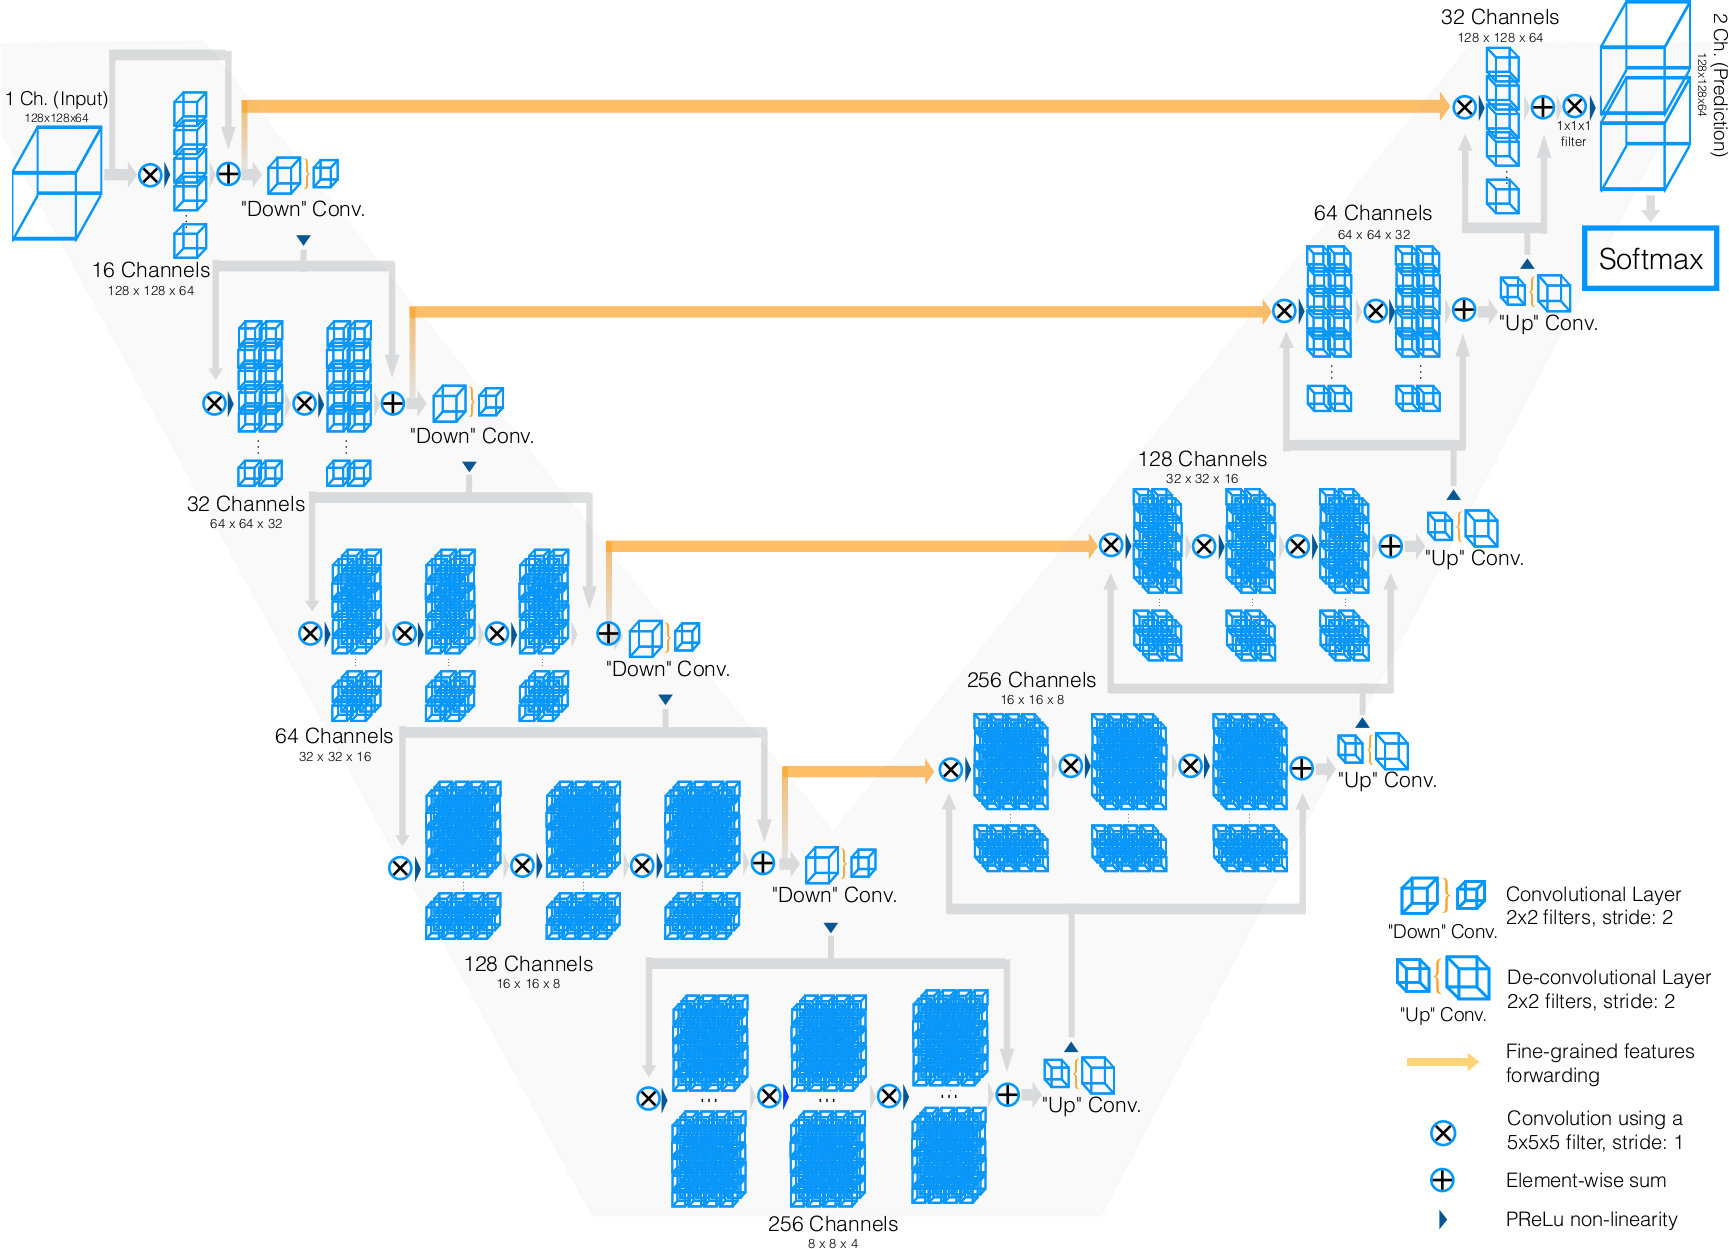

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['CUDA_VISIBLE_DEVICES']='3'

def passthrough(x, **kwargs):
    return x

def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)

# normalization between sub-volumes is necessary
# for good performance
class ContBatchNorm3d(nn.modules.batchnorm._BatchNorm):
    def __init__(self, num_features = 16):
        super(ContBatchNorm3d, self).__init__(num_features=16)
        self.num_features = num_features

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(nchan)
        self.bn1 = nn.BatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out


def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)


class InputTransition(nn.Module):
    def __init__(self, outChans, elu):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, outChans, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = ELUCons(elu, 16)

    def forward(self, x):
        # do we want a PRELU here as well?
        x1 = x
        x = self.conv1(x)
        out = self.bn1(x)
        # print(out.shape) # 1, 16, 16, 256, 256
        # print(x.shape)
        # split input in to 16 channels
        x16 = torch.cat((x1, x1, x1, x1, x1, x1, x1, x1,
                         x1, x1, x1, x1, x1, x1, x1, x1), 1)
        # print("x16", x16.shape)
        # print("out:", out.shape)
        # assert 1>3
        out = self.relu1(torch.add(out, x16))
        # print(out.shape) # 1, 16, 16, 256, 256
        # assert 1>3
        return out


class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2*inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=2, stride=2)
        # self.bn1 = ContBatchNorm3d(outChans)
        self.bn1 = nn.BatchNorm3d(outChans)
        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
    
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out


class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=2, stride=2)
        # self.bn1 = ContBatchNorm3d(outChans // 2)
        self.bn1 = nn.BatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        # print(x.shape, skipx.shape)
        
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        # print(out.shape, xcat.shape)
        # assert 1>3
        out = self.relu2(torch.add(out, xcat))
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, elu, nll):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, 1, kernel_size=5, padding=2)
        # self.bn1 = ContBatchNorm3d(2)
        self.bn1 = nn.BatchNorm3d(1)
        self.conv2 = nn.Conv3d(1, 1, kernel_size=1)
        self.relu1 = ELUCons(elu, 1)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(x.shape) # 1, 32, 64, 128, 128
        # assert 1>3
        # convolve 32 down to 2 channels
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = self.sigmoid(out)
        # print(out.shape)
        # assert 1>3
        # treat channel 0 as the predicted output
        return out


class VNet(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        self.in_tr = InputTransition(16, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, elu, nll)

    def forward(self, x):
        # print("x.shape:", x.shape)
        out16 = self.in_tr(x)
        # print("out16.shape:", out16.shape) # 1, 16, 64, 128, 128
        # assert 1>3
        out32 = self.down_tr32(out16)
        # print("out32.shape:", out32.shape) # 1, 32, 32, 64, 64
        # assert 1>3
        out64 = self.down_tr64(out32)
        # print("out64.shape:", out64.shape) # 1, 64, 16, 32, 32
        # assert 1>3
        out128 = self.down_tr128(out64)
        # print("out128.shape:", out128.shape) # 1, 128, 8, 16, 16
        # assert 1>3
        out256 = self.down_tr256(out128)
        # print("out256.shape", out256.shape) # 1, 256, 4, 8, 8
        # assert 1>3
        out = self.up_tr256(out256, out128)
        # print("out.shape:", out.shape)

        out = self.up_tr128(out, out64)
        # print("out:", out.shape)
        
        out = self.up_tr64(out, out32)
        # print("out:", out.shape)
        # assert 1>3
        out = self.up_tr32(out, out16)
        # print("last out:", out.shape)
        # assert 1>3
        out = self.out_tr(out)
        # print("out:", out.shape)
        return out

if __name__ == "__main__":
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VNet().to(device)

    input = torch.randn(1, 1, 16, 128, 128) # BCDHW 
    input = input.to(device)
    out = model(input) 
    print("output.shape:", out.shape) # 4, 1, 8, 256, 256

### lightning 完整示例

In [2]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [3]:
from ipywidgets import IntProgress


In [4]:
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset)

0it [00:00, ?it/s]

Extracting /mnt/ddnfs/data_users/yhwang/code/nbody2hydro/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting /mnt/ddnfs/data_users/yhwang/code/nbody2hydro/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting /mnt/ddnfs/data_users/yhwang/code/nbody2hydro/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting /mnt/ddnfs/data_users/yhwang/code/nbody2hydro/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


/home/yhwang/data/local/anaconda/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Done!


In [5]:
# init model
autoencoder = LitAutoEncoder()

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
trainer = pl.Trainer()
trainer.fit(autoencoder, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
/home/yhwang/data/local/anaconda/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/yhwang/data/local/anaconda/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1